In [1]:
import intel_extension_for_pytorch as ipex
from torchvision.datasets import CIFAR10, CelebA
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from torch.autograd import Variable
import torch
from tqdm import tqdm
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\hserg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\hserg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\hserg\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trainset = CIFAR10(root='../data', train=True,  transform=transforms.ToTensor(), download=True)
testset  = CIFAR10(root='../data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
BATCH_SIZE = 8
trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=8)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True, num_workers=8)

In [4]:
classes = {i:name for i, name in enumerate(trainset.classes)}
classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [5]:
imgs, labels = next(iter(trainloader))

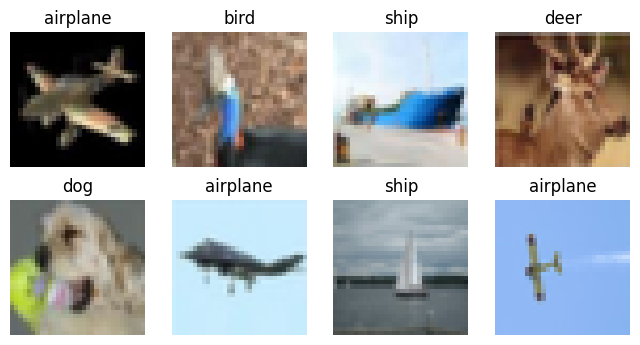

In [6]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1])
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

show_imgs(imgs[:8], labels[:8])

In [17]:
# class Generator(nn.Module):
#     def __init__(self, latent_dim: int, n_classes: int ):
#         super(Generator, self).__init__()
#         self.latent_dim = latent_dim
#         self.n_classes = n_classes
#         self.embeddings = nn.Embedding(num_embeddings=n_classes,
#                                        embedding_dim=latent_dim)
        
#         self.model = nn.Sequential(
#             nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
#             # ConvBlock2 (4x4)
#             nn.ConvTranspose2d(in_channels=latent_dim, 
#                                out_channels=256,
#                                kernel_size=4, 
#                                stride=1, bias=False),
#             nn.BatchNorm2d(num_features=256, momentum=0.9),
#             nn.LeakyReLU(negative_slope=0.15),
#             # ConvBlock3 (8x8)
#             nn.ConvTranspose2d(in_channels=256, 
#                                out_channels=128,
#                                kernel_size=4, 
#                                stride=2, 
#                                padding=1, bias=False),
#             nn.BatchNorm2d(num_features=128, momentum=0.9),
#             nn.LeakyReLU(negative_slope=0.15),
#             # ConvBlock4 (16x16)
#             nn.ConvTranspose2d(in_channels=128, 
#                                out_channels=64,
#                                kernel_size=4, 
#                                stride=2, 
#                                padding=1, bias=False), 
#             nn.BatchNorm2d(num_features=64, momentum=0.9),
#             nn.LeakyReLU(negative_slope=0.15),
#             # Final Conv Transpose (32x32)
#             nn.ConvTranspose2d(in_channels=64, 
#                                out_channels=3,
#                                kernel_size=4,
#                                stride=2, 
#                                padding=1, bias=False))
    
#     def forward(self, labels):
#         cls_embds = self.embeddings(labels)
#         eps = torch.randn_like(cls_embds)
#         return self.model(cls_embds + eps)

class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            # ConvBlock2 (4x4)
            nn.UpsamplingBilinear2d(size=(4,4)),
            nn.Conv2d(in_channels=latent_dim,
                      out_channels=256,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),            
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock3 (8x8)
            nn.UpsamplingBilinear2d(size=(8,8)),
            nn.Conv2d(in_channels=256,
                      out_channels=128,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock4 (16x16)
            nn.UpsamplingBilinear2d(size=(16,16)),
            nn.Conv2d(in_channels=128,
                      out_channels=64,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # Final Conv Transpose (32x32)
            nn.UpsamplingBilinear2d(size=(32,32)),
            nn.Conv2d(in_channels=64,
                      out_channels=3,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.Sigmoid())
    
    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)

In [18]:
class Discriminator(nn.Module):
    def __init__(self, n_classes: int, img_shape: Tuple):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=torch.prod(img_shape))
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=6,
                      out_channels=64,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=256, 
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0), 
            nn.Flatten(),
            nn.Sigmoid())
        
    def forward(self, input, labels):
        embds = self.embeddings(labels).view(input.shape)
        concat = torch.cat((input, embds), dim=1)
        return self.model(concat)

In [19]:
class ModelConfig:
    def __init__(self, batch_size, epochs, classes):
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.CLASSES = classes

In [20]:
# normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
class CGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(CGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_optimizer, g_loss,
                      d_optimizer, d_loss):
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss 
        self.d_loss = d_loss
    
    def forward(self, labels):
        with torch.inference_mode():
            out = self.generator(labels)      
        return out.detach()

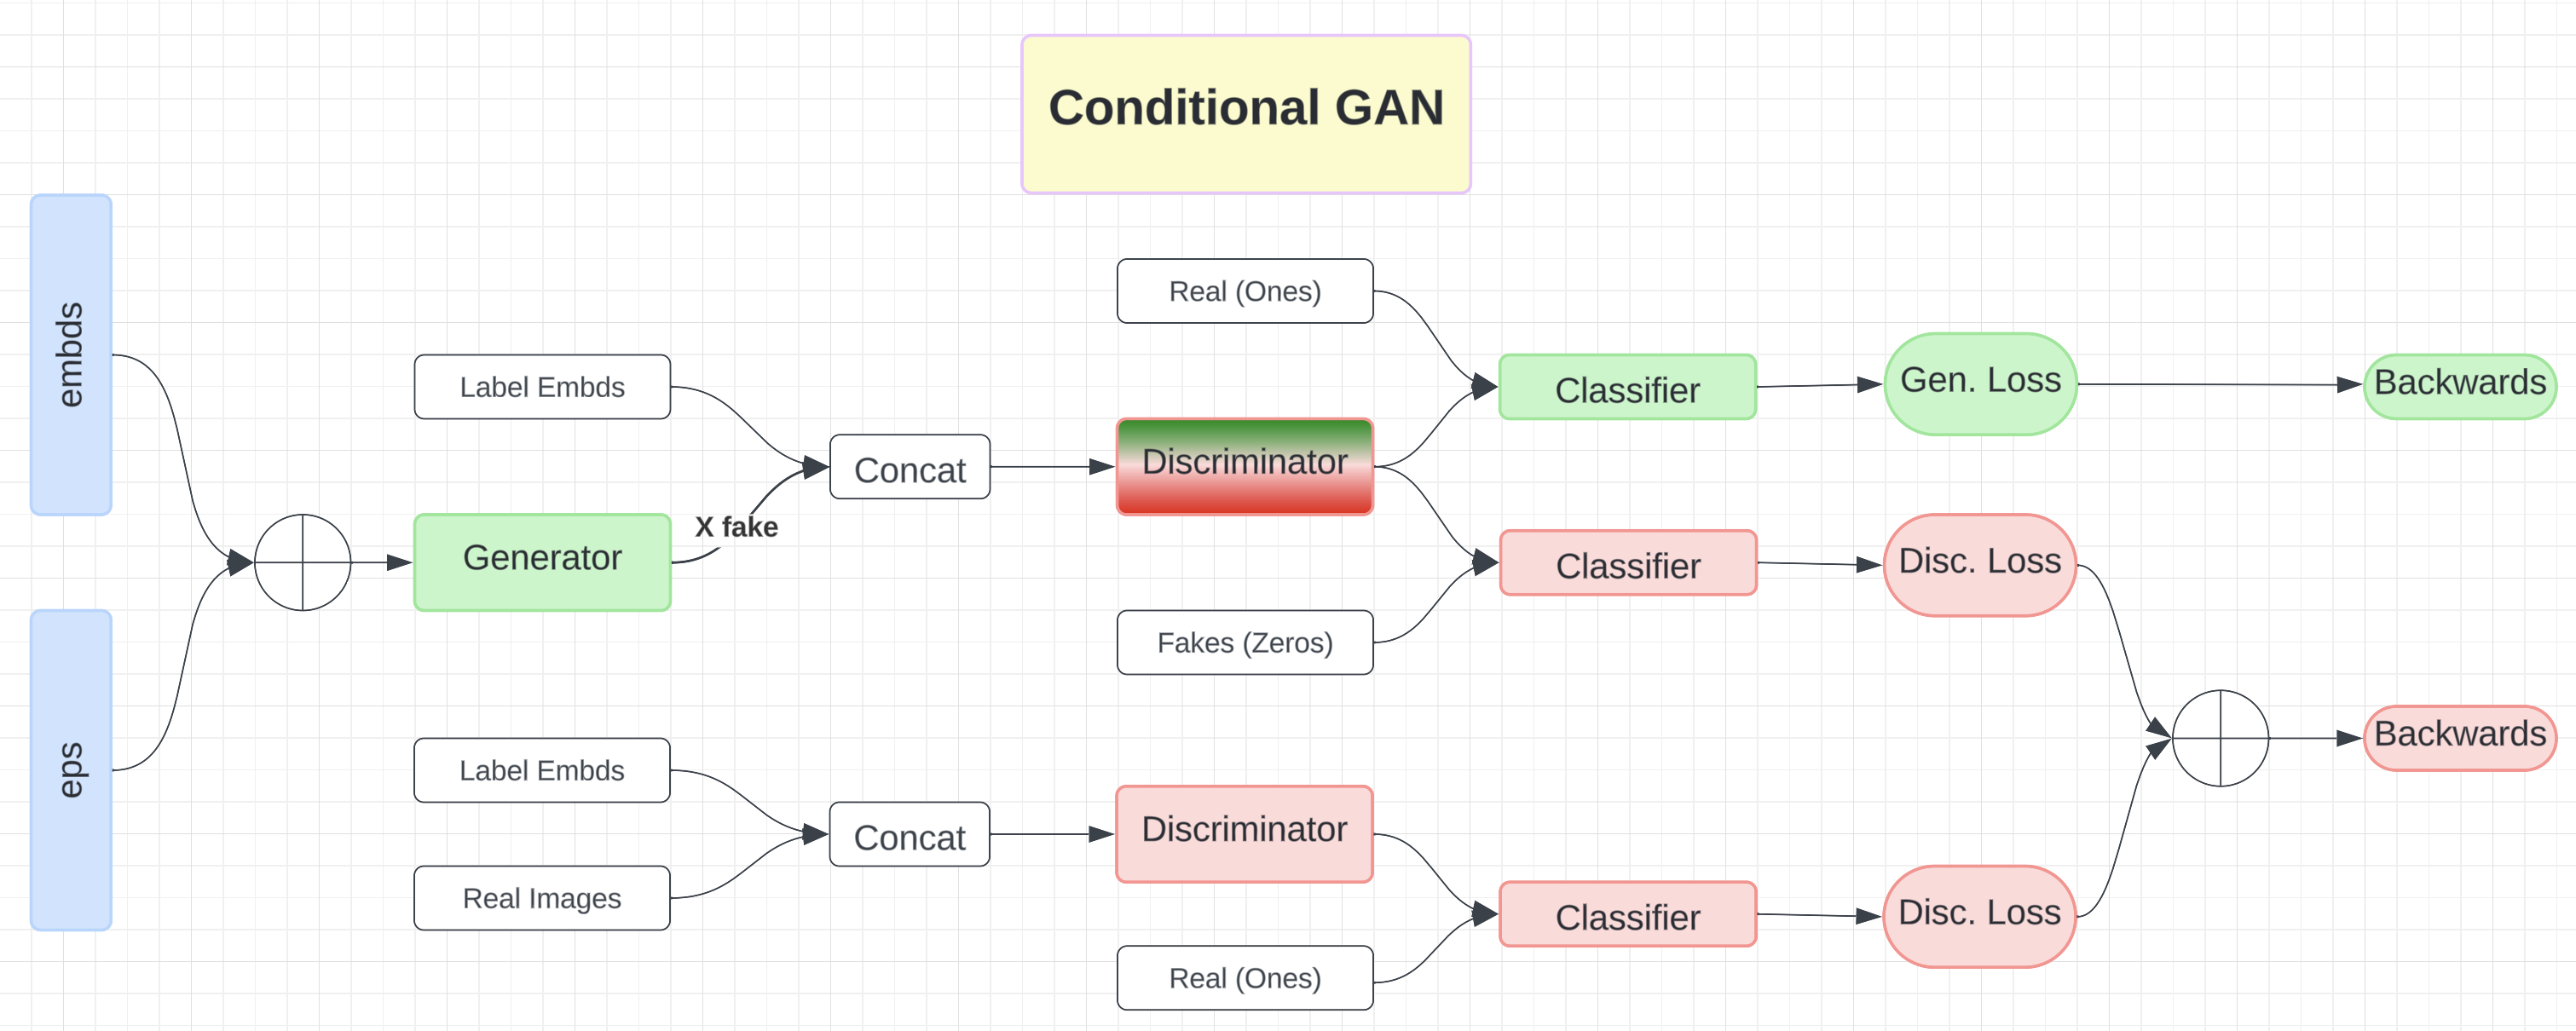

Epoch ----------> 1/3 | Trainig


  0%|          | 0/6250 [00:00<?, ?it/s]

100%|██████████| 6250/6250 [02:30<00:00, 41.60it/s]


Generator Loss: 3.2781
Disc. Fake Loss: 0.3045
Disc. Real Loss: 2118.8724
 Testing


100%|██████████| 1250/1250 [00:20<00:00, 60.18it/s] 
2024-02-13 19:58:17,675 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 19:58:17,684 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 19:58:17,694 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 19:58:17,702 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 19:58:17,710 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 19:58:17,719 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0

Generator Loss: 1.1292
Disc. Fake Loss: 0.6371
Disc. Real Loss: 0.6203


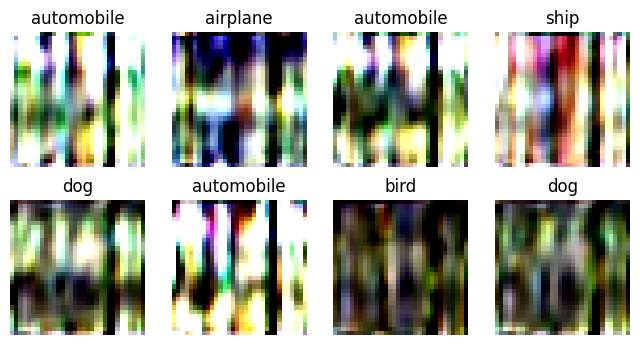

Epoch ----------> 2/3 | Trainig


100%|██████████| 6250/6250 [02:30<00:00, 41.39it/s]


Generator Loss: 4.9761
Disc. Fake Loss: 0.0615
Disc. Real Loss: 443.5944
 Testing


100%|██████████| 1250/1250 [00:20<00:00, 61.39it/s] 
2024-02-13 20:01:09,278 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:01:09,283 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:01:09,288 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:01:09,298 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:01:09,306 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:01:09,316 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0

Generator Loss: 0.9250
Disc. Fake Loss: 1.1561
Disc. Real Loss: 0.7326


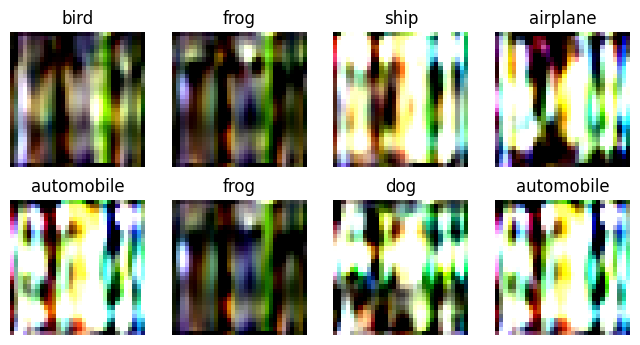

Epoch ----------> 3/3 | Trainig


100%|██████████| 6250/6250 [02:30<00:00, 41.46it/s]


Generator Loss: 5.1828
Disc. Fake Loss: 0.0644
Disc. Real Loss: 489.2563
 Testing


100%|██████████| 1250/1250 [00:21<00:00, 57.52it/s] 
2024-02-13 20:04:01,981 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:04:01,989 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:04:01,998 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:04:02,007 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:04:02,016 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:04:02,026 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0

Generator Loss: 1.0194
Disc. Fake Loss: 0.8208
Disc. Real Loss: 0.8525


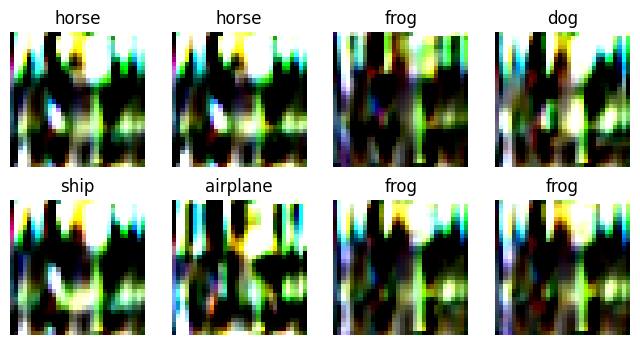

In [22]:
def train_step(model: nn.Module, trainloader: DataLoader,
               device: torch.device, metric: callable=None):
    
    mean_g_loss, mean_dfake_loss, mean_dreal_loss = .0, .0, .0
    for real_imgs, labels in tqdm(trainloader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # setting grads to 0 after last generator backprop
        model.d_optimizer.zero_grad()
        
        # labels for real&fake images
        ones = torch.ones_like(labels).unsqueeze(dim=-1).float()
        zeros = torch.zeros_like(labels).unsqueeze(dim=-1).float()
        
        # generated images conditioned on labels
        fake_imgs = model.generator(labels)
        
        # discriminator output based on fake&real images
        d_fake = model.discriminator(fake_imgs.detach(), labels)
        d_real = model.discriminator(real_imgs, labels)
        
        
        # discriminator loss using real real^fake labels
        d_fake_loss = model.d_loss(d_fake, zeros)
        d_real_loss = model.d_loss(d_real, ones)
        mean_dfake_loss += d_fake_loss.item()
        mean_dreal_loss += d_real_loss.item()
        
        d_total_loss = (d_fake_loss + d_real_loss)/2 

        # discriminator backpropagation
        d_total_loss.backward()
        model.d_optimizer.step()

        # generator backpropagation        
        model.g_optimizer.zero_grad()
        # print(fake_imgs.shape)
        d_fake = model.discriminator(fake_imgs, labels)
        g_loss = model.g_loss(d_fake, ones)
        
        mean_g_loss += g_loss.item()

        g_loss.backward()
        model.g_optimizer.step()

    n_batches = len(trainloader)
    mean_g_loss /= n_batches
    mean_dfake_loss /= n_batches
    return {"mean_g_loss":mean_g_loss,
            "mean_dfake_loss": mean_dfake_loss,
            "mean_dreal_loss": mean_dreal_loss}

def test_step(model: nn.Module, testloader: DataLoader,
              device: torch.device, metric: callable=None):
    
    mean_g_loss, mean_dfake_loss, mean_dreal_loss = .0, .0, .0
    with torch.inference_mode():
        for real_imgs, labels in tqdm(testloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            
            ones = torch.ones_like(labels).unsqueeze(dim=-1).float()
            zeros = torch.zeros_like(labels).unsqueeze(dim=-1).float()

            fake_imgs = model.generator(labels)
            d_fake = model.discriminator(fake_imgs, labels)
            
            d_real = model.discriminator(real_imgs, labels)
            mean_g_loss += model.g_loss(d_fake, ones).item()
            mean_dfake_loss += model.d_loss(d_fake, zeros).item()
            mean_dreal_loss += model.d_loss(d_real, ones).item()
            
        n_batches = len(testloader)
        mean_g_loss /= n_batches
        mean_dfake_loss /= n_batches 
        mean_dreal_loss /= n_batches
        
    return {"mean_g_loss":mean_g_loss,
            "mean_dfake_loss": mean_dfake_loss,
            "mean_dreal_loss": mean_dreal_loss}
        
def train(model: nn.Module, trainloader: DataLoader,
          testloader: DataLoader, device: torch.device, 
          EPOCHS: int, metric: callable=None):
    model = model.to(device)
    for epoch in range(EPOCHS):
        print(f"Epoch ----------> {epoch+1}/{EPOCHS} | Trainig")
        train_results = train_step(model, trainloader, device)
        print(f"Generator Loss: {train_results['mean_g_loss']:.4f}")
        print(f"Disc. Fake Loss: {train_results['mean_dfake_loss']:.4f}")
        print(f"Disc. Real Loss: {train_results['mean_dreal_loss']:.4f}")
        
        print(" Testing")
        test_results = test_step(model, testloader, device)
        print(f"Generator Loss: {test_results['mean_g_loss']:.4f}")
        print(f"Disc. Fake Loss: {test_results['mean_dfake_loss']:.4f}")
        print(f"Disc. Real Loss: {test_results['mean_dreal_loss']:.4f}")
        

        rand_labels = torch.randint(0, 10, (8,)).to(device)
        gen_imgs = model(rand_labels).to('cpu')
        show_imgs(gen_imgs, rand_labels.to('cpu'))

EPOCHS = 3
LATENT_DIM = 100
device = 'xpu' if ipex.xpu.is_available() else 'cpu'
# device = 'cpu'

generator = Generator(LATENT_DIM, len(classes))
discriminator = Discriminator(len(classes), torch.tensor(imgs[0].shape))

g_optimizer = optim.Adam(generator.parameters())
d_optimizer = optim.Adam(discriminator.parameters())

g_loss = nn.BCELoss()
d_loss = nn.BCELoss()

cgan = CGAN(generator, discriminator)
cgan.compile(g_optimizer, g_loss, 
             d_optimizer, d_loss)

train(cgan, trainloader, testloader, device, EPOCHS)


2024-02-13 20:10:08,747 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-02-13 20:10:08,753 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:10:08,758 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:10:08,762 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:10:08,768 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:10:08,772 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13 20:10:08,778 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-02-13

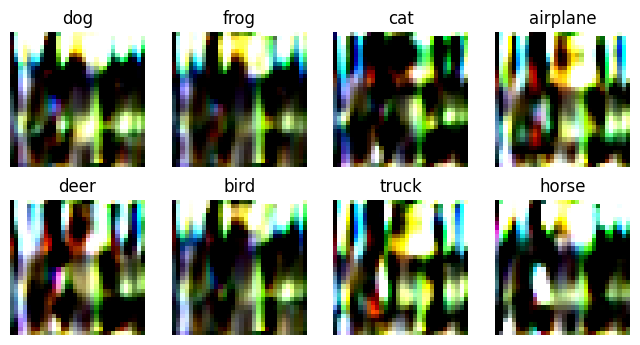

In [23]:
rand_labels = torch.randint(0, 10, (8,)).to(device)
gen_imgs = cgan(rand_labels).to('cpu')
show_imgs(gen_imgs, rand_labels.to('cpu'))